In [27]:
# Load necessary modules

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress as _linregress

In [28]:
# Functions 

def linregress(da_y, da_x, dim=None):
    '''xarray-wrapped function of scipy.stats.linregress.
    Note the order of the input arguments x, y is reversed to the original scipy function.'''
    if dim is None:
        dim = [d for d in da_y.dims if d in da_x.dims][0]
    slope, intercept, r, p, stderr = xr.apply_ufunc(_linregress, da_x, da_y,
        input_core_dims=[[dim], [dim]],
        output_core_dims=[[], [], [], [], []],
        vectorize=True,
        dask='allowed')
    predicted = da_x * slope + intercept
    slope.attrs['long_name'] = 'slope of the linear regression'
    intercept.attrs['long_name'] = 'intercept of the linear regression'
    r.attrs['long_name'] = 'correlation coefficient'
    p.attrs['long_name'] = 'p-value'
    stderr.attrs['long_name'] = 'standard error of the estimated gradient'
    predicted.attrs['long_name'] = 'predicted values by the linear regression model'
    return xr.Dataset(dict(slope=slope, intercept=intercept,
        r=r, p=p, stderr=stderr, predicted=predicted))

def area_weighted_ave(ds):
    if 'lat' not in ds.dims:
        ds = ds.rename({'latitude':'lat','longitude':'lon'})
    coslat = np.cos(np.deg2rad(ds.lat))
    ds,coslat = xr.broadcast(ds,coslat)
    ds = ds * coslat
    #return ds.mean(('lat','lon'),skipna=True)
    return ds.sum(('lat','lon'),skipna=True)/((ds/ds)*coslat).sum(('lat','lon'),skipna=True)

In [29]:
# Datasets
era5 = xr.open_dataset('/scratch/midway3/krucker01/ERA5/tmp_pl_1980-2024_regrid.nc').compute()
era5_land = xr.open_dataset('/project/tas1/ockham/data1/Katy_temp_folder/LSM_data/era5_land.nc')
era5_ocean = xr.open_dataset('/project/tas1/ockham/data1/Katy_temp_folder/LSM_data/era5_ocean.nc')


amip = xr.open_dataset('/project/tas1/ockham/data1/Katy_temp_folder/AMIP/amip_tmp_1981_2024.nc').compute()
amip = amip.rename({'lat': 'latitude','lon': 'longitude'})
amip['latitude'] = era5['latitude']
amip['longitude'] = era5['longitude']
amip_land = xr.open_dataset('/project/tas1/ockham/data1/Katy_temp_folder/LSM_data/amip_land.nc')
amip_ocean = xr.open_dataset('/project/tas1/ockham/data1/Katy_temp_folder/LSM_data/amip_ocean.nc')


#ace2 = xr.open_dataset('/project/tas1/ockham/data1/Katy_temp_folder/37_plev_ACE2_interp/ace2_interp_all_members_7-14-25_128x64.nc')
ace2 = xr.open_dataset('/project/tas1/ockham/data1/Katy_temp_folder/ACE2_37/ace2_37_t_interp_128x64.nc')
ace2 = ace2.T.compute()
ace2['latitude'] = era5['latitude']
ace2['longitude'] = era5['longitude']

#ace2_land = xr.open_dataset('/project/tas1/ockham/data1/Katy_temp_folder/37_plev_ACE2_interp/ace2_7-14-25_interp_ecmwf_extrap_land.nc')
#ace2_ocean = xr.open_dataset('/project/tas1/ockham/data1/Katy_temp_folder/37_plev_ACE2_interp/ace2_7-14-25_interp_ecmwf_extrap_ocean.nc')
ace2_land = xr.open_dataset('/project/tas1/ockham/data1/Katy_temp_folder/ACE2_37/ace2_37_t_interp_128x64_land.nc')
ace2_land = ace2_land.T
ace2_ocean = xr.open_dataset('/project/tas1/ockham/data1/Katy_temp_folder/ACE2_37/ace2_37_t_interp_128x64_ocean.nc')
ace2_ocean = ace2_ocean.T

ngcm = xr.open_dataset("/scratch/midway3/krucker01/ai-models/ngcm/climate_2.8_csp_pe/tmp_monthly_1981-2023_csp_pe.nc").compute()
ngcm['latitude'] = era5['latitude']
ngcm['longitude'] = era5['longitude']

ngcm_land = xr.open_dataset('/project/tas1/ockham/data1/Katy_temp_folder/LSM_data/ngcm_land.nc')
ngcm_ocean = xr.open_dataset('/project/tas1/ockham/data1/Katy_temp_folder/LSM_data/ngcm_ocean.nc')

In [30]:
# Geopotential Mask
mask_array = xr.open_dataset('/scratch/midway3/itbaxter/NeuralGCM_Decadal_Simulations/geopot_mask.nc')
mask = mask_array.__xarray_dataarray_variable__
mask = xr.where(mask, 1, np.nan)

In [31]:
title = '20N-60N'
lat1 = 20
lat2 = 60
year1 = '1981'
year2 = '2014'
min_percent = 0.05
max_percent = 0.95

In [32]:
# ERA5 trends

era5_tropics = area_weighted_ave(era5.t.sel(latitude=slice(lat1,lat2)).groupby('time.year').mean('time').sel(year=slice(year1,year2))*mask.sel(level=era5.level))
era5_trend = (linregress(era5_tropics,era5_tropics.year).slope*10).values

era5_land_tropics = area_weighted_ave(era5_land.t.sel(latitude=slice(lat1,lat2)).groupby('time.year').mean('time').sel(year=slice(year1,year2))*mask.sel(level=era5.level))
era5_land_trend = (linregress(era5_land_tropics,era5_land_tropics.year).slope*10).values

era5_ocean_tropics = area_weighted_ave(era5_ocean.t.sel(latitude=slice(lat1,lat2)).groupby('time.year').mean('time').sel(year=slice(year1,year2))*mask.sel(level=era5.level))
era5_ocean_trend = (linregress(era5_ocean_tropics,era5_ocean_tropics.year).slope*10).values

In [33]:
# AMIP trends 

amip_tropics = area_weighted_ave(amip.sel(latitude = slice(lat1,lat2)).groupby('time.year').mean('time').sel(year=slice(year1,year2))*mask.sel(level=amip.plev/100))
amip_tropics_array = amip_tropics.to_dataarray(dim='member_id')

amip_trend = (linregress(amip_tropics_array,amip_tropics_array.year).slope)*10

amip_trend_qts = np.nanquantile(amip_trend, [min_percent,max_percent], axis = 0)



amip_land_tropics = area_weighted_ave(amip_land.sel(latitude = slice(lat1,lat2)).groupby('time.year').mean('time').sel(year=slice(year1,year2))*mask.sel(level=amip.plev/100))
amip_land_tropics_array = amip_land_tropics.to_dataarray(dim='member_id')

amip_land_trend = (linregress(amip_land_tropics_array,amip_land_tropics_array.year).slope)*10

amip_land_trend_qts = np.nanquantile(amip_land_trend, [min_percent,max_percent], axis = 0)



amip_ocean_tropics = area_weighted_ave(amip_ocean.sel(latitude = slice(lat1,lat2)).groupby('time.year').mean('time').sel(year=slice(year1,year2))*mask.sel(level=amip.plev/100))
amip_ocean_tropics_array = amip_ocean_tropics.to_dataarray(dim='member_id')

amip_ocean_trend = (linregress(amip_ocean_tropics_array,amip_ocean_tropics_array.year).slope)*10

amip_ocean_trend_qts = np.nanquantile(amip_ocean_trend, [min_percent,max_percent], axis = 0)

In [34]:
# NGCM Trends 
ngcm_tropics = area_weighted_ave(ngcm.sel(latitude=slice(lat1,lat2)).groupby('time.year').mean('time').sel(year=slice(year1,year2))*mask.sel(level=ngcm.level))
ngcm_tropics_array = ngcm_tropics.to_dataarray(dim = 'member_id')

ngcm_trend = (linregress(ngcm_tropics_array,ngcm_tropics_array['year']).slope*10).values

ngcm_trend_qts = np.quantile(ngcm_trend, [min_percent,max_percent], axis = 0)


ngcm_land_tropics = area_weighted_ave(ngcm_land.sel(latitude=slice(lat1,lat2)).groupby('time.year').mean('time').sel(year=slice(year1,year2))*mask.sel(level=ngcm.level))
ngcm_land_tropics_array = ngcm_land_tropics.to_dataarray(dim = 'member_id')

ngcm_land_trend = (linregress(ngcm_land_tropics_array,ngcm_land_tropics_array['year']).slope*10).values

ngcm_land_trend_qts = np.quantile(ngcm_land_trend, [min_percent,max_percent], axis = 0)


ngcm_ocean_tropics = area_weighted_ave(ngcm_ocean.sel(latitude=slice(lat1,lat2)).groupby('time.year').mean('time').sel(year=slice(year1,year2))*mask.sel(level=ngcm.level))
ngcm_ocean_tropics_array = ngcm_ocean_tropics.to_dataarray(dim = 'member_id')

ngcm_ocean_trend = (linregress(ngcm_ocean_tropics_array,ngcm_ocean_tropics_array['year']).slope*10).values

ngcm_ocean_trend_qts = np.quantile(ngcm_ocean_trend, [min_percent,max_percent], axis = 0)

In [35]:
# ACE2 Trends
ace2_tropics = area_weighted_ave(ace2.sel(latitude=slice(lat1,lat2)).groupby('time.year').mean('time').sel(year=slice(year1,year2))*mask.sel(level=ace2.level))
ace2_trend = (linregress(ace2_tropics,ace2_tropics['year']).slope*10).values
ace2_trend_qts = np.nanquantile(ace2_trend, [min_percent,max_percent], axis = 0)


ace2_land_tropics = area_weighted_ave(ace2_land.sel(latitude=slice(lat1,lat2)).groupby('time.year').mean('time').sel(year=slice(year1,year2))*mask.sel(level=ace2.level))
ace2_land_trend = (linregress(ace2_land_tropics,ace2_land_tropics['year']).slope*10).values
ace2_land_trend_qts = np.nanquantile(ace2_land_trend, [min_percent,max_percent], axis = 0)


ace2_ocean_tropics = area_weighted_ave(ace2_ocean.sel(latitude=slice(lat1,lat2)).groupby('time.year').mean('time').sel(year=slice(year1,year2))*mask.sel(level=ace2.level))
ace2_ocean_trend = (linregress(ace2_ocean_tropics,ace2_ocean_tropics['year']).slope*10).values
ace2_ocean_trend_qts = np.nanquantile(ace2_ocean_trend, [min_percent,max_percent], axis = 0)

### 250-hPa Time Series 

In [36]:
# Select T250hPa
era5_250 = era5.sel(level = 250)

amip_250 = amip.sel(plev = 25000)

ace2_250 = ace2.sel(level = 200)

ngcm_250 = ngcm.sel(level = 250)

In [37]:
# Calculate time series 

# ERA5
era5_time = area_weighted_ave(era5_250.sel(latitude = slice(lat1,lat2))).groupby('time.year').mean('time')
era5_norm = era5_time - (era5_time.sel(year=slice(1980,1990)).mean().t)

# AMIP
amip_1 = amip_250.to_dataarray().mean('variable').sel(latitude = slice(lat1,lat2))
amip_time = area_weighted_ave(amip_1).groupby('time.year').mean('time')
amip_norm = amip_time-(amip_time.sel(year=slice(1980,1990)).mean())

# ACE2
ace2_time = area_weighted_ave(ace2_250.mean('member_id').sel(latitude = slice(lat1,lat2))).groupby('time.year').mean('time').sel(year=slice(1979,2021))
ace2_norm = ace2_time-(ace2_time.sel(year=slice(1980,1990)).mean())

# NGCM
ngcm_time = area_weighted_ave(ngcm_250.to_dataarray().mean('variable').sel(latitude = slice(lat1,lat2))).groupby('time.year').mean('time')
ngcm_norm = ngcm_time-(ngcm_time.sel(year=slice(1980,1990)).mean())

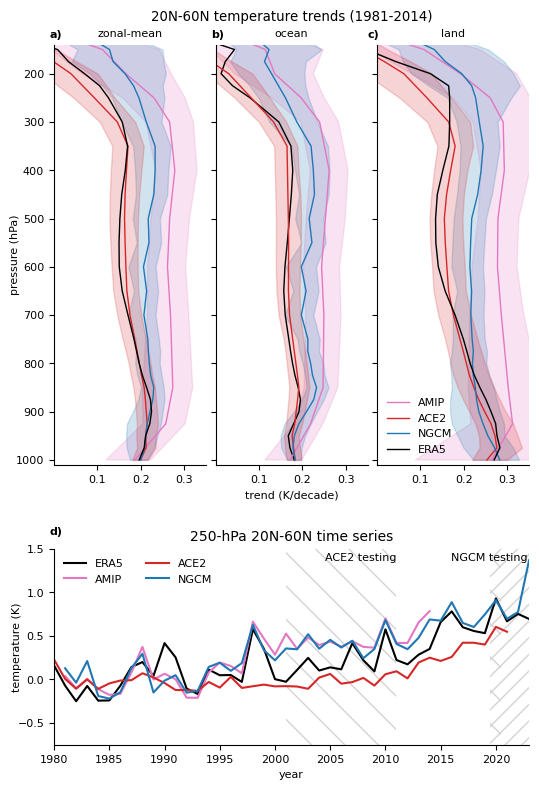

In [38]:
# Plotting
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
font = 8
line = 1
plt.rc('font', size=font)
fig = plt.figure(figsize=(4.75,  7))#, layout = 'constrained')
plt.axis('off')
plt.suptitle(title+' temperature trends ('+year1+'-'+year2+')', y=1.05)
plt.rcParams['hatch.color'] = 'lightgray'

fig.text(-0.01,1.01, 'a)', weight = 'bold', fontsize = font)
fig.text(0.33,1.01, 'b)', weight = 'bold', fontsize = font)
fig.text(0.66,1.01, 'c)', weight = 'bold', fontsize = font)
fig.text(-0.01,0.3, 'd)', weight = 'bold', fontsize = font)

ax = fig.add_axes([0,0.4,0.32,0.6])
ax.set_rasterized(True)
ax.plot(np.nanmean(amip_trend, axis = 0), amip.plev/100, color='#E377C2', linewidth=line)
ax.plot(np.nanmean(ace2_trend,axis=0), ace2.level, color='#D62728', linewidth=line)
ax.plot(ngcm_trend.mean(0), ngcm.level, color='#1F77B4', linewidth=line)
ax.plot(era5_trend, era5.level, color='k', linewidth=line)
ax.fill_betweenx(amip.plev/100, amip_trend_qts[0], amip_trend_qts[1], color = '#E377C2', alpha = 0.2)
ax.fill_betweenx(ngcm.level, ngcm_trend_qts[0], ngcm_trend_qts[1], color = '#1F77B4', alpha = 0.2)
ax.fill_betweenx(ace2.level, ace2_trend_qts[0], ace2_trend_qts[1], color = '#D62728', alpha = 0.2)



#plt.legend(['AMIP','ACE2','NGCM', 'ERA5'], loc = 'lower right', frameon = False, fontsize = font)



ax.yaxis.set_inverted(True)
ax.set_ylim(1010, 140)
ax.set_yticks(np.arange(1000,199,-100))
ax.set_xlim(0, 0.035*10)
ax.set_xticks([0.01*10,0.02*10,0.3])
ax.tick_params(axis = 'both', labelsize = font)

#ax.set_xlabel(r'Trend (K Decade$^{-1}$)',fontsize=font+2)
ax.set_ylabel('pressure (hPa)',fontsize=font, labelpad = -3)
ax.set_title("zonal-mean", fontsize = font)

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

ax = fig.add_axes([0.34,0.4,0.32,0.6])
ax.set_rasterized(True)
ax.plot(era5_ocean_trend, era5_ocean.level, color='k', linewidth=line)
ax.plot(np.nanmean(amip_ocean_trend, axis = 0), amip_ocean.plev/100, color='#E377C2', linewidth=line)
ax.plot(np.nanmean(ace2_ocean_trend,axis=0), ace2.level, color='#D62728', linewidth=line)
ax.plot(ngcm_ocean_trend.mean(0), ngcm_ocean.level, color='#1F77B4', linewidth=line)
ax.fill_betweenx(amip_ocean.plev/100, amip_ocean_trend_qts[0], amip_ocean_trend_qts[1], color = '#E377C2', alpha = 0.2)
ax.fill_betweenx(ngcm_ocean.level, ngcm_ocean_trend_qts[0], ngcm_ocean_trend_qts[1], color = '#1F77B4', alpha = 0.2)
ax.fill_betweenx(ace2_ocean.level, ace2_ocean_trend_qts[0], ace2_ocean_trend_qts[1], color = '#D62728', alpha = 0.2)


ax.yaxis.set_inverted(True)
ax.set_ylim(1010, 140)
ax.set_yticklabels([])
ax.set_xlim(0, 0.035*10)
ax.set_xticks([0.01*10,0.02*10,0.3])
ax.tick_params(axis = 'x', labelsize = font)

ax.set_xlabel('trend (K/decade)',fontsize=font)
#ax.set_ylabel('Pressure (hPa)',fontsize=14)
ax.set_title("ocean", fontsize = font)

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

ax = fig.add_axes([0.68,0.4,0.32,0.6])
ax.set_rasterized(True)
ax.plot(np.nanmean(amip_land_trend, axis = 0), amip_land.plev/100, color='#E377C2', linewidth=line)
ax.plot(np.nanmean(ace2_land_trend,axis=0), ace2.level, color='#D62728', linewidth=line)
ax.plot(ngcm_land_trend.mean(0), ngcm_land.level, color='#1F77B4', linewidth=line)
ax.plot(era5_land_trend, era5_land.level, color='k', linewidth=line)
ax.fill_betweenx(amip_ocean.plev/100, amip_land_trend_qts[0], amip_land_trend_qts[1], color = '#E377C2', alpha = 0.2)
ax.fill_betweenx(ngcm_land.level, ngcm_land_trend_qts[0], ngcm_land_trend_qts[1], color ='#1F77B4', alpha = 0.2)
ax.fill_betweenx(ace2_land.level, ace2_land_trend_qts[0], ace2_land_trend_qts[1], color = '#D62728', alpha = 0.2)

plt.legend(['AMIP','ACE2','NGCM', 'ERA5'], loc = 'lower left', frameon = False, fontsize = font)#, bbox_to_anchor = (1.2, 0))

ax.yaxis.set_inverted(True)
ax.set_ylim(1010, 140)
ax.set_yticklabels([])
ax.set_xlim(0, 0.035*10)
ax.set_xticks([0.01*10,0.02*10,0.3])
ax.tick_params(axis = 'x', labelsize = font)

#ax.set_xlabel(r'Trend (K Decade$^{-1}$)',fontsize=font)
#ax.set_ylabel('Pressure (hPa)',fontsize=14)
ax.set_title("land", fontsize = font)

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

ax = fig.add_axes([0,0,1,0.28])
ax.plot(era5_norm.year[:-1], era5_norm.t[:-1], color = 'k', label = 'ERA5')
ax.plot(amip_norm.year, amip_norm, color = '#E377C2', label = 'AMIP')
ax.plot(ace2_norm.year, ace2_norm, color = '#D62728', label = 'ACE2')
ax.plot(ngcm_norm.year, ngcm_norm, color = '#1F77B4', label = 'NGCM')

plt.axvspan(2001, 2011, facecolor='none', hatch = "\\")
plt.axvspan(2020-0.5, 2020+0.5, facecolor='none', hatch = '\\')
plt.axvspan(2020-0.5,2024, facecolor = 'none', hatch = '//')
# ax.text(2011,-0.74, 'ACE2 testing', ha = 'right', va = 'bottom', rotation = 90, fontsize = font)
# ax.text(2023,-0.74, 'NGCM testing', ha = 'right', va = 'bottom', rotation = 90, fontsize = font)
ax.text(2011,1.45, 'ACE2 testing', ha = 'right', va = 'top', fontsize = font)
ax.text(2022.9,1.45, 'NGCM testing', ha = 'right', va = 'top', fontsize = font)


ax.set_xlim([1980,2023])
ax.set_ylim([-0.75,1.5])
ax.set_yticks([-0.5,0,0.5,1.0,1.5])
ax.set_title(f'250-hPa {title} time series', fontsize = font+2)
ax.set_xlabel('year',fontsize=font)
ax.set_ylabel('temperature (K)',fontsize=font, labelpad= -3)
ax.tick_params(axis = 'both', labelsize = font)
plt.legend(bbox_to_anchor = None, loc = 'upper left', frameon=False, ncol = 2, fontsize = font)

#plt.tight_layout()

plt.savefig('Thermo_Fig_2_'+title+'.eps', dpi = 550, bbox_inches='tight', )